In [207]:
import pandas_datareader.data as pdr
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [208]:
df1 = pd.read_csv('AAPL.csv')

In [209]:
df1.tail()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1253,1253,AAPL,2020-05-18 00:00:00+00:00,314.96,316.50,310.3241,313.17,33843125,314.96,316.50,310.3241,313.17,33843125,0.0,1.0
1254,1254,AAPL,2020-05-19 00:00:00+00:00,313.14,318.52,313.0100,315.03,25432385,313.14,318.52,313.0100,315.03,25432385,0.0,1.0
1255,1255,AAPL,2020-05-20 00:00:00+00:00,319.23,319.52,316.2000,316.68,27876215,319.23,319.52,316.2000,316.68,27876215,0.0,1.0
1256,1256,AAPL,2020-05-21 00:00:00+00:00,316.85,320.89,315.8700,318.66,25672211,316.85,320.89,315.8700,318.66,25672211,0.0,1.0
1257,1257,AAPL,2020-05-22 00:00:00+00:00,318.89,319.23,315.3500,315.77,20450754,318.89,319.23,315.3500,315.77,20450754,0.0,1.0


In [210]:
end_date = '2020-05-22'
df = df1.reset_index()['close']

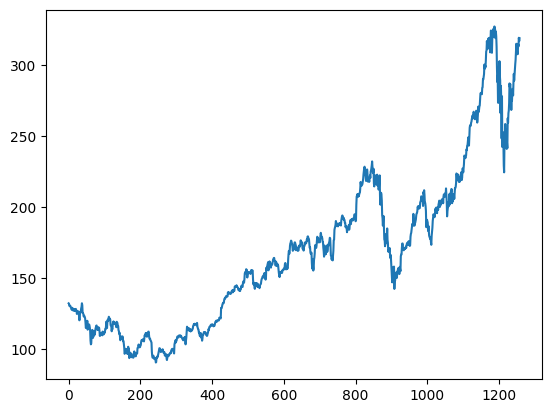

In [211]:
plt.plot(df)

In [212]:
#LSTM is sensitive to scale of data, so we apply MinMax Scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(np.array(df).reshape(-1,1))

In [213]:
training_size = int(len(df)*0.65)
test_size = len(df)-training_size
train_data, test_data = df[0:training_size,:], df[training_size:len(df),:]

In [214]:
print(train_data.shape), print(test_data.shape)

(817, 1)
(441, 1)


(None, None)

In [215]:
# x_train = []
# y_train = []
# for iter in range(150, 817):
#     x_train.append(train_data[iter-150:iter, 0])
#     y_train.append(train_data[iter, 0])
# x_train, y_train=np.array(x_train), np.array(y_train)
# print(x_train.shape)
# print(y_train.shape)
# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [216]:
def create_dataset(n_step, data):
    x_train = []
    y_train = []
    for iter in range(n_step, len(data)):
        x_train.append(data[iter-n_step:iter, 0])
        y_train.append(data[iter, 0])
    return np.array(x_train), np.array(y_train)

In [217]:
n_step = 100
X_train, y_train = create_dataset(100, train_data)
print(X_train.shape)
print(y_train.shape)

(717, 100)
(717,)


In [218]:
X_test, y_test = create_dataset(100, test_data)
print(X_test.shape)
print(y_test.shape)

(341, 100)
(341,)


In [219]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [220]:
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential

In [221]:
model = Sequential()
# return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
# we wont use return sequence true in last layers as we dont want to previous output
model.add(LSTM(50))
model.add(Dropout(0.2))
# Output layer , we wont pass any activation as its continous value model
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\E0551793\OneDrive - Eaton\BLC-Saloni\BITSPilani\StockMarketPrediction\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [222]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [223]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 335ms/step - loss: 0.0268 - val_loss: 0.0625
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 319ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 522ms/step - loss: 0.0016 - val_loss: 0.0039
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 292ms/step - loss: 0.0015 - val_loss: 0.0065
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - loss: 0.0014 - val_loss: 0.0058
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 311ms/step - loss: 0.0011 - val_loss: 0.0052
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - loss: 0.0011 - val_loss: 0.0055
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - loss: 0.0012 - val_loss: 0.0052
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step - loss: 0.0013 - val_loss: 0.0041
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - loss: 0.0013 - val_loss: 0.0047


In [224]:
y_pred = model.predict(X_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step


In [225]:

##Transformback to original form
y_pred=scaler.inverse_transform(y_pred)

In [226]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_test,y_pred))

229.53636127269792

In [227]:
future_dates = pd.date_range(start=end_date, periods=30)
last_price = df[-n_step:]
scaled_price = scaler.transform(last_price.reshape(-1,1))

In [228]:
x_pred = np.array([scaled_price[-n_step:, 0]])
x_pred = x_pred.reshape(x_pred.shape[0], x_pred.shape[1], 1)

In [229]:
predic_price = model.predict(x_pred)
predic_price = scaler.inverse_transform(predic_price)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


In [230]:
print(future_dates.shape)
print(future_dates)

(30,)
DatetimeIndex(['2020-05-22', '2020-05-23', '2020-05-24', '2020-05-25',
               '2020-05-26', '2020-05-27', '2020-05-28', '2020-05-29',
               '2020-05-30', '2020-05-31', '2020-06-01', '2020-06-02',
               '2020-06-03', '2020-06-04', '2020-06-05', '2020-06-06',
               '2020-06-07', '2020-06-08', '2020-06-09', '2020-06-10',
               '2020-06-11', '2020-06-12', '2020-06-13', '2020-06-14',
               '2020-06-15', '2020-06-16', '2020-06-17', '2020-06-18',
               '2020-06-19', '2020-06-20'],
              dtype='datetime64[ns]', freq='D')


In [231]:
print(predic_price.shape)
print(predic_price)

(1, 1)
[[12.673714]]


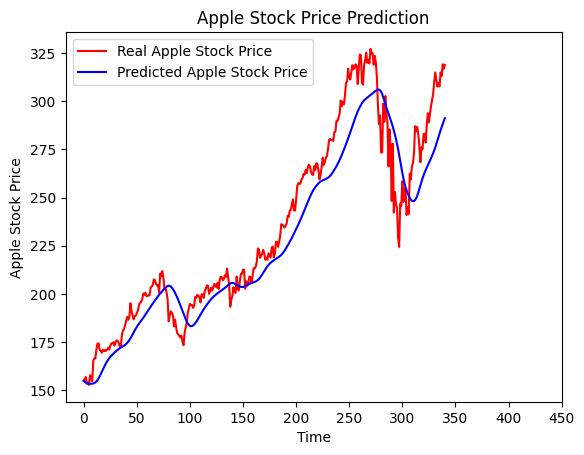

In [233]:

y_actual=scaler.inverse_transform(y_test.reshape(-1,1))
plt.plot(y_actual, color = 'red', label = 'Real Apple Stock Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Apple Stock Price')
plt.xticks(np.arange(0,459,50))
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()